
# Projeto Nadir
Desenvolvimento do Projeto de Conclusão de Curso da Pós-Graduação BI-Master da PUC-Rio lecionada pelo Laboratório ICA que será chamado de projeto Nadir.<br><br>
O objetivo a ser atingido é:


*   Criar uma Rede Neural capaz de classificar imagens de constelações

Por se tratar de uma Prova de Conceito, será abordado apenas 4 constelações:
1. Órion
2. Cruzeiro do Sul
3. Cão Maior
4. Ursa Menor







In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import imutils
from imutils import paths
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

workdir_path = '/content/drive/My Drive/Colab Notebooks/TCC' #MODIFICAR!!! #Caminho para o seu workspace
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Definição de Funções de Apoio para o desenvolvimento do projeto

In [ ]:
dicionario = {
    0: 'canis major',
    1: 'crux',
    2: 'orion',
    3: 'ursa minor'
}

In [ ]:
#Testa 1 imagem já lida e pré-processada
def testImage(model, image, label_real, dicionario = dicionario):
    plt.imshow(image)
    plt.title(dicionario[np.argmax(label_real)])
    plt.xlabel("Prediction: " + (dicionario[np.argmax(model.predict(image.reshape(-1,224,224,3)))]))
    plt.show()

In [ ]:
#Testa um conjunto de 8 imagens simultaneamente
def gridImage8(model, image, label_real, inicio = 0, dicionario = dicionario):
  plt.figure(figsize=(25,10))
  for i in range(8):
    a = 240 + i + 1
    plt.subplot(int(a))
    plt.imshow(image[i + inicio])
    plt.title(dicionario[np.argmax(label_real[i + inicio])])
    plt.xlabel("Prediction: " + (dicionario[np.argmax(model.predict(image[i + inicio].reshape(-1,224,224,3)))]))

  plt.show()

In [ ]:
def matrix(labels, prediction):

  y = [np.argmax(ans) for ans in labels]
  pred = [np.argmax(ans) for ans in prediction]

  print(classification_report(y, pred))
  print('--------------------------------------')
  plt.figure(figsize=(5,5))
  plt.title('Matriz de Confusão')
  sns.heatmap(confusion_matrix(y, pred), annot=True, cbar=False, square=True)
  plt.savefig('confusion_matrix.png')
  plt.show()

# Lendo os Dados

In [ ]:
all = '/content/drive/My Drive/Colab Notebooks/TCC/dataset/all/'

Lendo as labels existentes e registrando

In [ ]:
labels = os.listdir(all)

In [ ]:
#Teste de código
labels[0]

'canis major'

Lendo os dados e armazenando em variáveis

In [ ]:
#Lendo os dados
X = []
y = []
for label in labels:

  caminhos = list(paths.list_images(all +  label))

  for caminho in caminhos:
    image = cv2.imread(caminho)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    y.append(label)
    X.append(image)

Convertantendo para os formatos necessários

In [ ]:
X, y = np.array(X)/255.0, np.array(y)

canis major
--------------------------


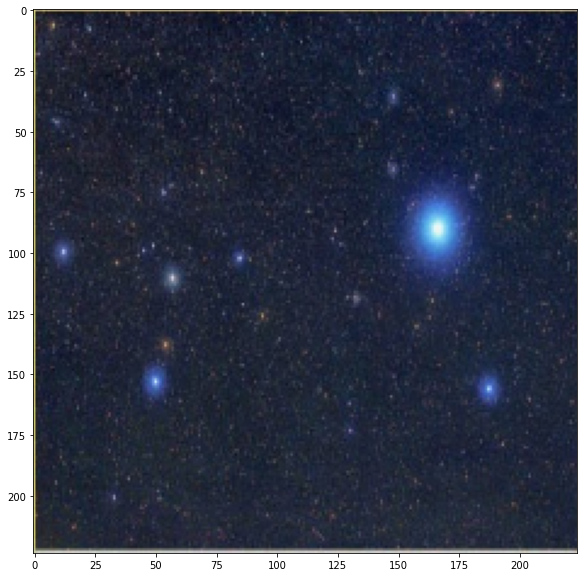

In [ ]:
#Checando se está tudo certo
print(y[0])
plt.figure(figsize=(10,10))
plt.imshow(X[0]);
print('--------------------------')

ursa minor
--------------------------


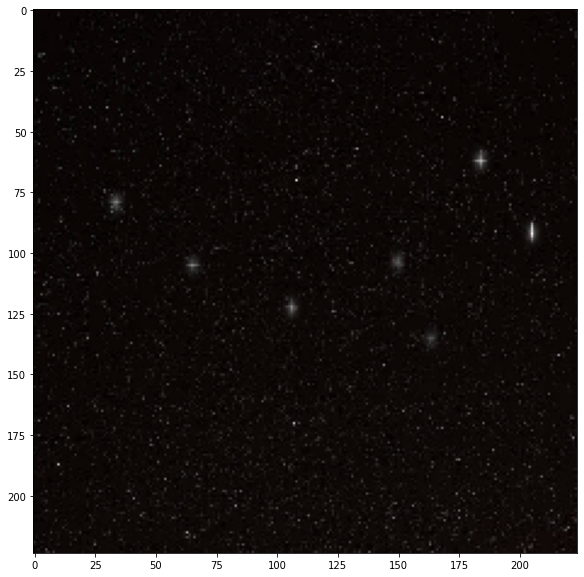

In [ ]:
print(y[5])
plt.figure(figsize=(10,10))
plt.imshow(X[5]);
print('--------------------------')

# Data Augmentation

Devido ao baixo número de imagens obtidas para o treinamento e teste da Rede Neural, se faz necessário gerar novas imagens sintéticas a partir das imagens originais obtidas

Montando o gerador de imagens:

In [ ]:
#Data Augmentation
DataGen = ImageDataGenerator(
 rotation_range=30, zoom_range=0.3, width_shift_range=0.3, height_shift_range = 0.3,featurewise_center=True,
    featurewise_std_normalization=True, horizontal_flip=True
)

In [ ]:
batch_size = 16

data_generator = DataGen.flow(X, np.array(pd.get_dummies(y)), 
                                     batch_size=batch_size, 
                                     shuffle=True)

Teste do gerador de imagens:

In [ ]:
x_, y_ = data_generator.__next__()

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
pd.get_dummies(y).head()

,canis major,crux,orion,ursa minor
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [ ]:
y_[0]

array([0, 0, 1, 0], dtype=uint8)

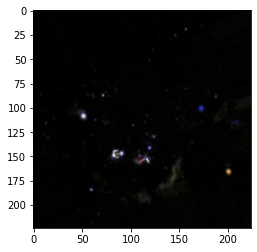

In [ ]:
plt.imshow(x_[0]);

Gerando imagens novas:

In [ ]:
train_steps_per_epoch = X.shape[0]//batch_size + 1

increase_by=40
steps_per_epoch = train_steps_per_epoch*increase_by
train_features=[]
train_labels=[]
for i in range(steps_per_epoch):
    print("\rTraining Batches: {}/{}\n".format(i+1,steps_per_epoch), end="")
    x_,y_ = data_generator.__next__()
    train_features.append(x_)
    train_labels.append(y_)
    


train_features = np.concatenate(train_features,axis=0)
train_labels = np.concatenate(train_labels,axis=0)


print('\nCreation of vectors image finished!')

Training Batches: 1/80
Training Batches: 2/80


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Training Batches: 3/80
Training Batches: 4/80
Training Batches: 5/80
Training Batches: 6/80
Training Batches: 7/80
Training Batches: 8/80
Training Batches: 9/80
Training Batches: 10/80
Training Batches: 11/80
Training Batches: 12/80
Training Batches: 13/80
Training Batches: 14/80
Training Batches: 15/80
Training Batches: 16/80
Training Batches: 17/80
Training Batches: 18/80
Training Batches: 19/80
Training Batches: 20/80
Training Batches: 21/80
Training Batches: 22/80
Training Batches: 23/80
Training Batches: 24/80
Training Batches: 25/80
Training Batches: 26/80
Training Batches: 27/80
Training Batches: 28/80
Training Batches: 29/80
Training Batches: 30/80
Training Batches: 31/80
Training Batches: 32/80
Training Batches: 33/80
Training Batches: 34/80
Training Batches: 35/80
Training Batches: 36/80
Training Batches: 37/80
Training Batches: 38/80
Training Batches: 39/80
Training Batches: 40/80
Training Batches: 41/80
Training Batches: 42/80
Training Batches: 43/80
Training Batches: 44/80

In [ ]:
print(f'Quantidade de imagens geradas a serem usadas é: {train_labels.shape[0]}')

Quantidade de imagens geradas a serem usadas é: 1080


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, train_size = 0.8, stratify = train_labels, random_state = 42)

In [ ]:
X_train.shape

(864, 224, 224, 3)

In [ ]:
y_train #Colocar quantas classes tem por y pra mostrar que está estratificado

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1]], dtype=uint8)

# Montando o Modelo

Será usado Transfer Learning usando de base a rede VGG16

In [ ]:
model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
INIT_LR = 1e-3
EPOCHS = 1000
BS = 32

In [ ]:
headmodel = model_vgg.output
headmodel = Flatten(name="flatten")(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(64, activation='relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(4, activation='softmax')(headmodel)

model = Model(inputs = model_vgg.input, outputs = headmodel, name='Nadir')

for layer in model_vgg.layers:
  layer.trainable = False

opt = SGD(learning_rate=INIT_LR, decay=INIT_LR/EPOCHS)

model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "Nadir"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
callbacks = [
    ReduceLROnPlateau(patience=20, factor=0.5, verbose=True),
    ModelCheckpoint('best.model', save_best_only=True),
    EarlyStopping(patience=40, verbose=True)
]


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.2)

In [ ]:
h = model.fit(
    X_train, y_train,
    batch_size = BS,
    validation_data = (X_val, y_val), 
    epochs = EPOCHS,
    callbacks = callbacks
)

Epoch 1/1000
22/22 [==============================] - 9s 253ms/step - loss: 1.5709 - accuracy: 0.2935 - val_loss: 1.3049 - val_accuracy: 0.3699
INFO:tensorflow:Assets written to: best.model/assets
Epoch 2/1000
22/22 [==============================] - 3s 152ms/step - loss: 1.3652 - accuracy: 0.3420 - val_loss: 1.3243 - val_accuracy: 0.3410
Epoch 3/1000
22/22 [==============================] - 3s 153ms/step - loss: 1.3467 - accuracy: 0.3291 - val_loss: 1.3097 - val_accuracy: 0.3931
Epoch 4/1000
22/22 [==============================] - 3s 154ms/step - loss: 1.3218 - accuracy: 0.3578 - val_loss: 1.2602 - val_accuracy: 0.4913
INFO:tensorflow:Assets written to: best.model/assets
Epoch 5/1000
22/22 [==============================] - 3s 156ms/step - loss: 1.2845 - accuracy: 0.3708 - val_loss: 1.2356 - val_accuracy: 0.3873
INFO:tensorflow:Assets written to: best.model/assets
Epoch 6/1000
22/22 [==============================] - 3s 156ms/step - loss: 1.2880 - accuracy: 0.3809 - val_loss: 1.2359 

# Avaliação do modelo

<Figure size 432x288 with 0 Axes>

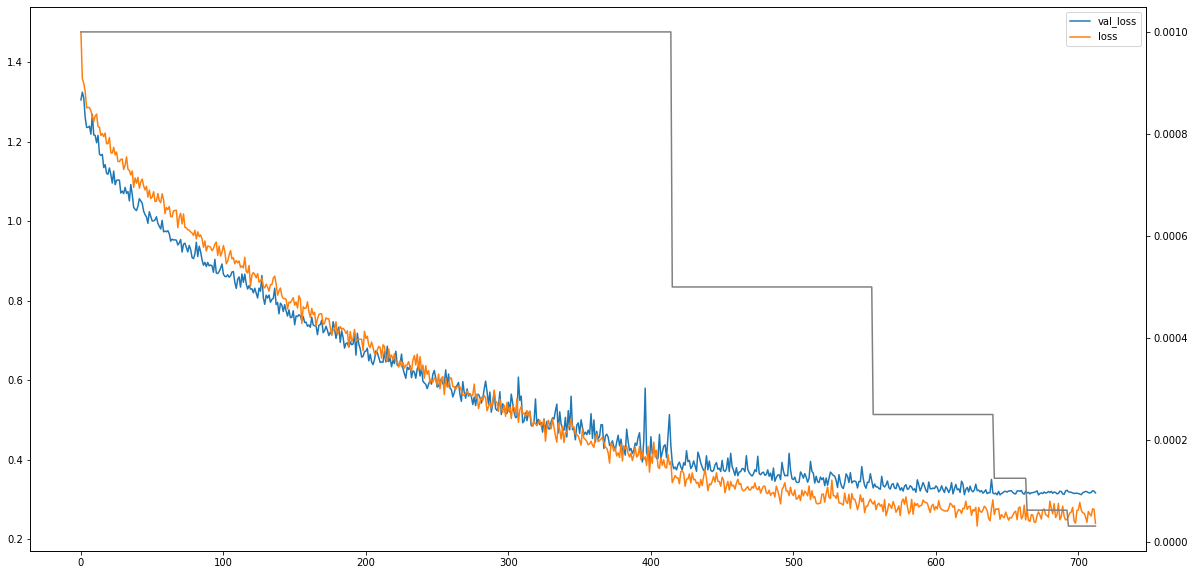

In [ ]:
df_history = pd.DataFrame(h.history)

fig = plt.figure();
ax = df_history[['val_loss', 'loss']].plot(figsize=(20, 10));
df_history['lr'].plot(ax=ax.twinx(), color='gray');
plt.savefig('loss_val_loss_lr.png')

<Figure size 432x288 with 0 Axes>

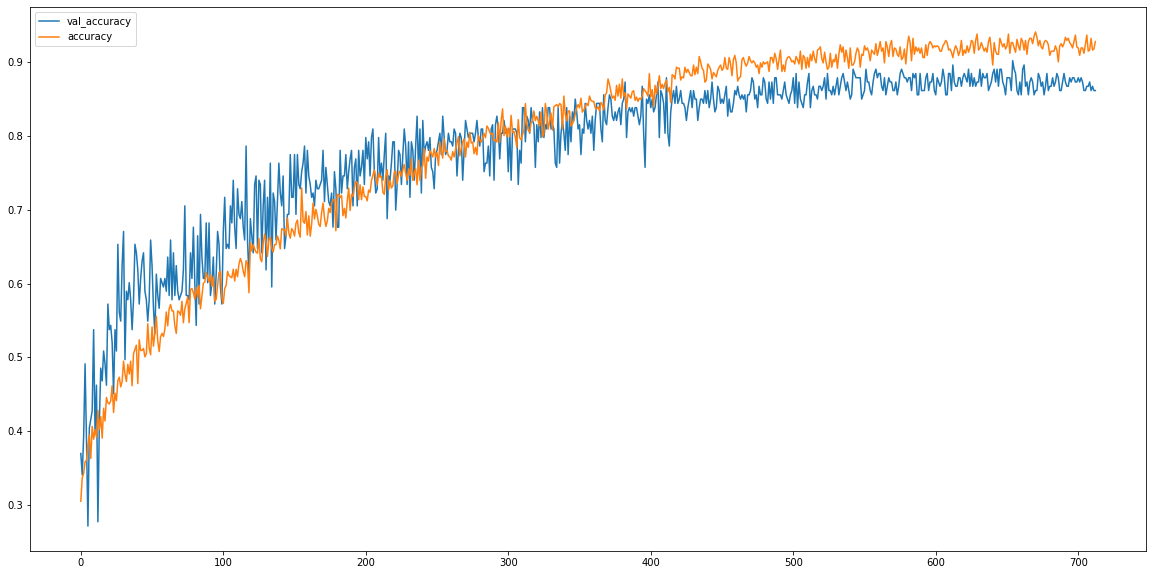

In [ ]:
fig = plt.figure();
ax = df_history[['val_accuracy', 'accuracy']].plot(figsize=(20, 10));
plt.savefig('accuracy_val_accuracy.png')

In [ ]:
df_history.tail()

,loss,accuracy,val_loss,val_accuracy,lr
708,0.262585,0.916064,0.315634,0.872832,0.000031
709,0.257766,0.931983,0.317452,0.861272,0.000031
710,0.275867,0.916064,0.321387,0.867052,0.000031
711,0.274664,0.917511,0.320343,0.861272,0.000031
712,0.239172,0.927641,0.316104,0.861272,0.000031


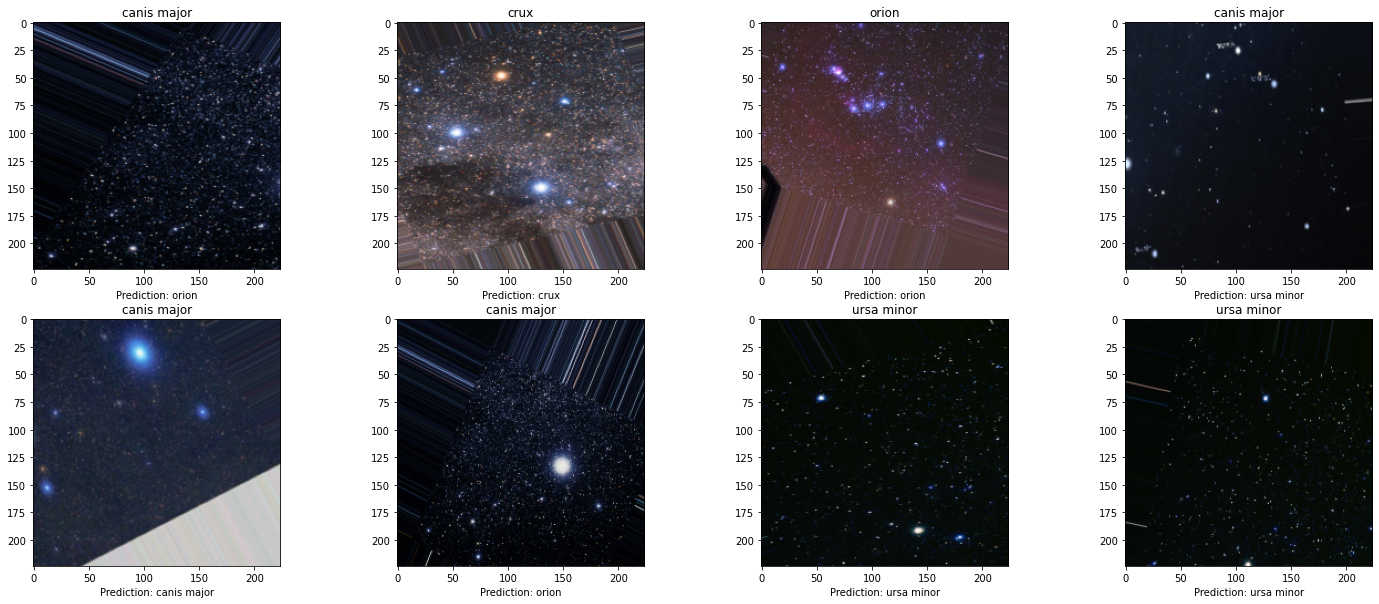

In [ ]:
gridImage8(
    model,
    X_test,
    y_test,
    inicio = 10
)

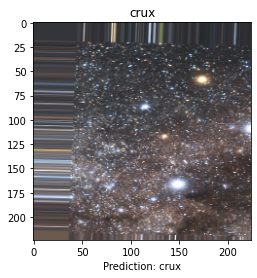

In [ ]:
testImage(
    model,
    X_test[0],
    y_test[0]
)

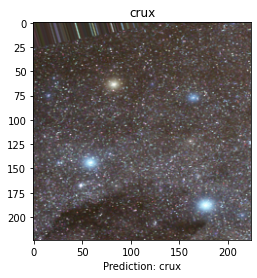

In [ ]:
testImage(
    model,
    X_test[1],
    y_test[1]
)

In [ ]:
pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.73      0.55      0.63        40
           1       0.98      0.83      0.90        64
           2       0.79      0.95      0.87        64
           3       0.84      0.96      0.89        48

    accuracy                           0.84       216
   macro avg       0.84      0.82      0.82       216
weighted avg       0.85      0.84      0.84       216

--------------------------------------


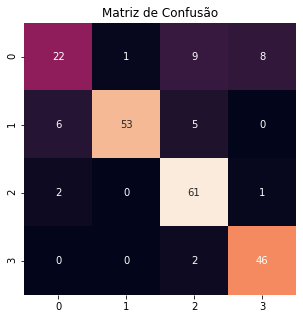

In [ ]:
matrix(y_test, pred)

In [ ]:
df_history.to_csv('df_history.csv')

In [ ]:
model.save('oficial_nadir_model')

INFO:tensorflow:Assets written to: oficial_nadir_model/assets


In [ ]:
model.save('oficial_nadir_model.tf')

INFO:tensorflow:Assets written to: oficial_nadir_model.tf/assets


In [ ]:
model.save('oficial_nadir_model.h5')